# Visualizing your NLP data: An Orientation with a Sorted Bar Plot

* This homework is building on cells from the previous assignment, and then moving on to show you how to visualize the data.
* We'll start with the usual **pip installs** you need:
    * **pip install numpy**
    * **pip install seaborn**
    * **pip install matplotlib**


In [2]:
# !pip install saxonche
# !pip install pathlib

import os
import pathlib
from pathlib import Path
import spacy
import re as regex
# re lets us work with regular expressions in Python
from saxonche import PySaxonProcessor
from os import getcwd
# this lets us retrieve the current working directory

/usr/local/lib/python3.11/site-packages/thinc/compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
/usr/local/lib/python3.11/site-packages/thinc/compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


Remember the spaCy language models? Let's try loading loading the large one to get the maximum amount of information from it! 
There's a lot we can experiment with from spaCy, so here's a link to the documentation for our ready reference:
<https://spacy.io/usage/spacy-101> 

We're going to start by just reviewing its POS (part of speech) and NER (named entity recognition) taggers to see what we can see in your project files.


In [3]:
# nlp = spacy.cli.download("en_core_web_lg")
# ONLY NEED ABOVE LINE ONCE. REMEMBER: COMMENT OUT THE ABOVE LINE THE NEXT TIME YOU RUN THIS.
nlp = spacy.load('en_core_web_lg')

Okay, let's explore some project files!
We've loaded the XML directory prepared by the Futurama team for our example here. 

* If you have some basic XML right now, like the Futurama team has prepared, we can easily scope in tagged sections of your collection. Swap out the Futurama collection with yours, and adjust the Python code below accordingly.
* If you don't have XML at this point, you can work around this over text files, or just explore the Futurama collection.

In [4]:
# DEFINE SOME FILE PATHS FOR INPUT, AND (ONCE WE'RE READY) OUTPUT
InputPath = 'futurama-xml'
OutputPath = 'testOutput' 

# You can SKIP the next (XPath) code block for now 
(We're leaving it for review: we'll find a good use for it later).

The next cell demonstrates the xpath() function, set up to run over individual files.
Let's look at how it returns information about distinct values of speakers. We're exploring distinct-values() and count() functions here. Try removing them and putting them back to see what the effect of distinct-values() is on the count. 


In [5]:
def readTextFiles(InputPath):
    # This function uses XPath to read the XML input
    for file in os.listdir(InputPath):
        if file.endswith('.xml'):
            filepath = f"{InputPath}/{file}"
            with PySaxonProcessor(license=False) as proc:
                xml = open(filepath, encoding='utf-8').read()
                # ebb: Here we apply the Saxon processor to read files with XPath.
                xp = proc.new_xpath_processor()
                node = proc.parse_xml(xml_text=xml)
                xp.set_context(xdm_item=node)

                # From here on, we select the string that Python will send to NLP. 
                # xpath = xp.evaluate('//your/xpath/here')
                xpath = xp.evaluate('//speak/@who => distinct-values() => sort()')
                count = xp.evaluate('//speak/@who => distinct-values() => count()')
                string = str(xpath)
                print(xpath)
                # xpath is going to go file by file.
             
readTextFiles(InputPath)

"AMY"
"BENDER"
"DJ"
"FARNSWORTH"
"FRY"
"HERMES"
"JOE"
"KIF"
"LEELA"
"MARTIAN"
"MARTIAN #2"
"MR WONG"
"MRS WONG"
"RJ"
"SINGING WIND"
"ZAPP"
"ZOIDBERG"
"ALL"
"BENDER"
"CLERK"
"COMPUTER VOICE"
"CONGREGATION"
"FRAKES"
"FRY"
"KIF"
"KOENIG"
"LEELA"
"MAN"
"MELLLVAR"
"MELLLVARS"
"NICHOLS"
"NIMOY"
"PRIEST"
"SHATNER"
"TAKEI"
"WELSHY"
"ZAPP"
"ZOIDBERG"
"AMY"
"AUSTRALIAN GUY"
"BENDER"
"BUREACRATS"
"EVERYBODY"
"FARNSWORTH"
"FRY"
"GRADE 11"
"GRADE 20"
"GRADE 41"
"GRADE 53"
"HERMES"
"IPGEE"
"LABARBARA"
"LEELA"
"LOU"
"MORGAN"
"NUMBER 1"
"OLD MAN"
"TERRY"
"WRIST THING"
"ZOIDBERG"
"AMY"
"ANNOUNCER"
"BENDER"
"BOY"
"COUNTESS"
"CROUPIER"
"FARNSWORTH"
"FRY"
"HATTIE"
"HERMES"
"IZAC"
"KIF"
"LABARBARA"
"LEELA"
"MR WONG"
"MRS WONG"
"POOPENMEYER"
"ZAPP"
"ZOIDBERG"
"AMY"
"BARRIERBOT #1"
"BARRIERBOT #2"
"BENDER"
"CUBERT"
"ELZAR"
"FARNSWORTH"
"FRY"
"GUARDBOT #1"
"GUARDBOT #2"
"GUARDBOT #3"
"GUARDBOT #4"
"HERMES"
"HOLOFARNSWORTH"
"LEELA"
"MAN #1"
"MAN #2"
"UNIVERSAL TRANSLATOR"
"VERNON"
"ZOIDBERG"
"ALL"
"AMY"
"AUSTR

## XQuery Blocks
Review: XQuery is what we want to use to help read data from across a whole directory, or "corpus" collection of files. 
XQuery can be written as a separate file (with .xql or .xquery extension) in oXygen over a directory. But we will find it more useful 
to apply it in Python if we're working on natural language processing applications. 

### Setting up XQuery in Python 
We use the same "boilerplate" PySaxonProcessor lines, but switch from xpath to the xquery processor.


Requirements: 
* We need all the xq lines to plug this processing into Python. You can use this code as a starter for your projects.
* The XQuery script is written inside a quoted block in the set_query_content() function that needs to take a quoted string, just like in the cell below.
* We need the run_query_to_value() function to execuit the script we're writing.
  

**Reading the collection**: We're setting this up to read a `collection()` function, which is a directory of XML files. 
**Writing XQuery**: This involves setting simple variables equal to xpath expressions. XQuery variables are defined with a `$`.
**XQuery Comments**: look like sideways smiley faces. `(: I'm an XQuery comment :)`

Let's take a look:



In [6]:
def xqueryOverFiles(InputPath):
    # This time, let's try XQuery over a collection of files:
    with PySaxonProcessor(license=False) as proc:
        print(proc.version)
        xq = proc.new_xquery_processor()
        # This only works on Mac / Linux: xq.set_query_base_uri('file://'+getcwd()+'/')
        xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
        xq.set_query_content('''
let $futurama := collection('futurama-xml/?select=*.xml')
let $speakers := $futurama//speak/@who => distinct-values() => sort()
let $count := count($speakers)
return $speakers

   (: ebb: I'm writing in an XQuery comment, and pointing out you can define and return any variable you want in the XQuery zone. :)
   (: ebb: Try changing this one to return $speakers instead of the $count variable. :)
   (: ebb: We're writing an query-based syntax called FLWOR (pronounced "flower") and every FLWOR requires a return statement at the end. :)
    
''')
        r = xq.run_query_to_value()
        print(r)  
                               
xqueryOverFiles(InputPath)

SaxonC-HE 12.3 from Saxonica
"5-EYES"
"AARON JR"
"AARON SR"
"AD ROCK"
"ADLAI"
"AHAB"
"AKI"
"ALBERT"
"ALBRIGHTBOT"
"ALEX"
"ALIEN"
"ALIENS"
"ALKAZAR"
"ALL"
"ALPHABOT"
"AMAZONIAN"
"AMAZONIANS"
"AMBASSADOR MOIVIN"
"AMY"
"AMY 1"
"AMY 420"
"ANDERSON"
"ANDREW"
"ANDY"
"ANGLEYNE"
"ANNOUNCER"
"ANNOUNCER #1"
"ANNOUNCER #2"
"ANTONIO"
"ARACHNEON"
"ARMY ROBOT"
"ARTHUR"
"ATILLA THE HUN"
"AUCTIONEER"
"AUDIENCE"
"AUSTRALIAN GUY"
"AUTOPILOT"
"BABE"
"BAILIFF"
"BAILLIF"
"BARBADOS SLIM"
"BARKER"
"BARMAN"
"BARRIERBOT #1"
"BARRIERBOT #2"
"BARTENDER"
"BARTENDERBOT"
"BEASTIE BOYS"
"BECK"
"BEE"
"BEELER"
"BEES"
"BENDER"
"BENDER 1"
"BENDER 1729"
"BENDER AND BECK"
"BENDER AND BENDER 1"
"BENDER FIGURINE"
"BENDING UNIT"
"BESERK"
"BETABOT"
"BETAMAX PLAYER"
"BIDDER #1"
"BIDDER #2"
"BIG BRAIN"
"BIG EARED MUTANT"
"BIG MOUTHED MUTANT"
"BIKE THIEF"
"BILL"
"BILLIONAIREBOT"
"BILLY"
"BLUE ELDER"
"BOLT"
"BONT"
"BOOTH VOICE"
"BOY"
"BRAIN #1"
"BRAIN #2"
"BRAIN #3"
"BRAIN BALL #1"
"BRAIN BALL #2"
"BRET"
"BROKERBOT #1"
"BROKERBOT

## What's the difference? 

Notice that you return just one count for the entire collection, not 72 different counts for the speakers in each file.
How can we use this? 

We can get pull information from across the entire collection and find out literally who has the most speeches in the whole series. 
Take a look at this code. Don't worry if you don't know how to write it yet. I just want to show you for demonstration purposes! 
What's here is a nearly full "FLWOR statement" which stands for :

* For
* Let
* Where
* Order by
* Return

The only things required in a FLWOR statements are L and R. The others give you extra powers like we're seeing here.

**IMPORTANT: You're only allowed one return per FLWOR.**



In [7]:
def xqueryOverFiles(InputPath):
    # This time, let's try XQuery over a collection of files:
    with PySaxonProcessor(license=False) as proc:
        print(proc.version)
        xq = proc.new_xquery_processor()
        xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
        xq.set_query_content('''
let $futurama := collection('futurama-xml/?select=*.xml')
let $speakers := $futurama//speak/@who => distinct-values() => sort()
let $count := count($speakers)
for $sp in $speakers
    let $count := $futurama//speak[@who = $sp] => count()
    where $count > 100
    order by $count descending
    return ($sp || ':  ' || $count)
 
''')
        r = xq.run_query_to_value()
        print(r)  
                            

xqueryOverFiles(InputPath)


SaxonC-HE 12.3 from Saxonica
"FRY:  2684"
"BENDER:  2360"
"LEELA:  2117"
"FARNSWORTH:  990"
"ZOIDBERG:  581"
"AMY:  499"
"HERMES:  408"
"ZAPP:  336"
"KIF:  197"
"CALCULON:  114"


For this notice how we can move **deliberately** in XQuery from information on the whole collection, to information based on individuals in a series.
The counts we're seeing are NOT based on files, but on info about each speaker! 

## For statements, measurements, order by, return


* Let's choose a character from Futurama who gets a LOT of speeches and use XQuery to pull all their speeches from across the entire collection into one return.
The next code block is written to show you how to get all the speeches of one character in the WHOLE collection. You can change this to any other character you wish.
* Let's go through each speech individually and meaasure it: 
* Try out defining a new variable in the XQuery, to use the `string-length()` function, so you can measure the text of the speeches. Try it out!

* We're going to write a for statement so we can evaluate each speech, and order our results based on how long the speeches are,
     * We'll use the XPath `string-length()` function to measure each speech
     * We'll work through an XQuery `for` and `order by`
     * Let's see if we can return the speeches from shortest to longest, then try adding the word `descending` to order them longest to shortest!


* YOUR TURN: Edit the code below to return some alternative information! 

In [8]:
def xqueryAndNLP(InputPath):
    # This time, let's try XQuery over a collection of files:
    with PySaxonProcessor(license=False) as proc:
        print(proc.version)
        xq = proc.new_xquery_processor()
        xq.set_query_base_uri(Path('.').absolute().as_uri() + '/')
        xq.set_query_content('''
let $futurama := collection('futurama-xml/?select=*.xml')
let $benderSpeeches := $futurama//speak[@who="BENDER"]
let $benderTextsOnly := $benderSpeeches/text() 
for $bt in $benderTextsOnly
   let $length := $bt ! string-length()
   where $length gt 20
   order by $length descending
   return $bt
''')
        # We started with this: r = xq.run_query_to_value() 
        # If you use this you need to convert r to a string in Python. r = str(run_query_to_value())
        # There's a run_query_to_string() option that's convenient so I'm using it here! 
        r = xq.run_query_to_string()
        return r
        # print(r)                          

## Experimenting with some functions


Remember how we were going to apply some NLP from spaCy? The next part of this exercise is to take the output of this XQuery function and pass it to the spaCY language model!

We need XQuery in our function above to return just one string if we want to deliver that to spaCY and NLP tools. The way I left this code, it's returning thousands of strings.

* So here's your challenge: Write some code that returns all the text of a different speaker. (Or adjust the code to use in your project.)
* The `r` variable is storing the XQuery output. I have updated `r` to be xq.run_query_to_string() which should output a single string. If it syou can convert it to a single string in Python with `str()`.
* Then make sure it's returning a single string when you print(r). You may need to convert `r` 
* **Write some new code** that delivers this single string to be processed with spaCy in some way.
    * You can build your code in a new cell block below this one.
    *  You'll probably want to review [this spaCy NLP assignment](https://github.com/newtfire/textAnalysis-Hub/blob/main/python-nlp-exercise1.md#write-some-python-code-to-do-the-following)
    * Write your code to return any information of interest from spaCy, following the spaCy documentation as we did in that earlier assignment! Try looking for one or two different kinds of language. What are the most popular verbs, adjectives, nouns? Try out the NER (named entity recognition)...Write your code in your copy of this Jupyter Notebook to complete this exercise. 

In [9]:
from collections import Counter
inputstring = xqueryAndNLP(InputPath)
# start playing with spaCy and nlp:
benderWords = nlp(inputstring)
# print(benderWords)


BenderLemmas = []
for token in benderWords:
    if token.pos_ == "VERB":
        lemma = token.lemma_
        BenderLemmas.append(lemma)

# Okay, we'll use python's Counter() find out how frequently each verb lemma shows up in the entire verb list.
# Counter() removes duplicates and counts the number of times something appears. 
# And it outputs a dictionary of key:value pairs already sorted from highest to lowet count.

lemmaFreq = Counter(BenderLemmas)

print(f"Lemma frequency {lemmaFreq}")

# We can even calculate the percentage each verb is used.
# The totalVerbCount will be the length of the BenderLemmas list.

totalVerbCount = len(BenderLemmas) 
# print(f"total verb count: {totalVerbCount}")


        

SaxonC-HE 12.3 from Saxonica
Lemma frequency Counter({'get': 214, 'go': 175, 'do': 115, 'have': 115, 'say': 90, 'know': 89, 'make': 84, 'come': 79, 'look': 74, 'let': 72, 'think': 69, 'take': 56, 'want': 52, 'see': 52, 'love': 42, 'mean': 41, 'need': 39, 'kill': 38, 'wait': 34, 'give': 34, 'be': 34, 'call': 34, 'try': 33, 'feel': 31, 'tell': 31, 'use': 27, 'like': 27, 'find': 25, 'stop': 25, 'keep': 21, 'hear': 20, 'bend': 20, 'save': 19, 'live': 19, 'wanna': 19, 'remember': 19, 'steal': 18, 'eat': 18, 'build': 18, 'help': 17, 'shut': 17, 'forget': 17, 'put': 17, 'work': 17, 'run': 16, 'win': 16, 'guess': 15, 'happen': 15, 'die': 14, 'hurt': 13, 'meet': 13, 'believe': 13, 'check': 12, 'hit': 12, 'move': 12, 'bring': 12, 'leave': 12, 'ask': 11, 'care': 11, 'talk': 11, 'show': 11, 'turn': 10, 'break': 10, 'hold': 10, 'start': 10, 'hate': 10, 'watch': 10, 'mind': 10, 'bite': 10, 'miss': 10, 'drink': 9, 'walk': 9, 'hope': 9, 'pay': 9, 'cook': 9, 'comin': 9, 'pick': 9, 'fight': 9, 'lose': 8

## Plotting some output in SVG
Here's how to do this with the seaborn library. You can work with a range of palettes here optimized in different ways for displaying graph data.
First some installs. matplotlib and seaborn libraries work together when we start plotting. These are some frequently used visualization libraries in Python, and you can customize them for display in jupyter notebooks.

In [10]:
#!pip install numpy 
#!pip install seaborn
#!pip install matplotlib

# Counter is an amazing Python module: it's going to save us some lines of code.
# We'll use it when we want to get count information of how often distinct forms of a word occur in our colleciton. 
# Fun things to do with Counter: https://realpython.com/python-counter/#plotting-categorical-data-with-matplotlib
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns

### How much to plot? And how to display? 
If we're displaying in a Jupyter Notebook, there are some display configurations to set, marked with a `%` in the next cell. 

We don't want to plot every last word here. But we have a lot of data, so we can experiment
To access data in our Counter list and keep it organized from highest to lowest value, we use `most_common()`.
Then we can slice it to store however many we want to plot. [:10] would plot the first 11 values since python starts counting from zero.

### Seaborn Library 
This library is a favorite among developers because it's easy to use and configure. 

#### YOUR ASSIGNMENT 
Change the display of data in the following ways:
* Change the selection and amount of data being plotted
* Change the color / appearance of the plot on consulting Seaborn's documentation on color palettes: https://seaborn.pydata.org/tutorial/color_palettes.html 

mostCommon Lemmas {'get': 214, 'go': 175, 'do': 115, 'have': 115, 'say': 90, 'know': 89, 'make': 84, 'come': 79, 'look': 74, 'let': 72, 'think': 69, 'take': 56, 'want': 52, 'see': 52, 'love': 42, 'mean': 41, 'need': 39, 'kill': 38, 'wait': 34, 'give': 34, 'be': 34, 'call': 34, 'try': 33, 'feel': 31, 'tell': 31, 'use': 27, 'like': 27, 'find': 25, 'stop': 25, 'keep': 21, 'hear': 20, 'bend': 20, 'save': 19, 'live': 19, 'wanna': 19, 'remember': 19, 'steal': 18, 'eat': 18, 'build': 18, 'help': 17, 'shut': 17, 'forget': 17, 'put': 17, 'work': 17}
[214, 175, 115, 115, 90, 89, 84, 79, 74, 72, 69, 56, 52, 52, 42, 41, 39, 38, 34, 34, 34, 34, 33, 31, 31, 27, 27, 25, 25, 21, 20, 20, 19, 19, 19, 19, 18, 18, 18, 17, 17, 17, 17, 17]
['get', 'go', 'do', 'have', 'say', 'know', 'make', 'come', 'look', 'let', 'think', 'take', 'want', 'see', 'love', 'mean', 'need', 'kill', 'wait', 'give', 'be', 'call', 'try', 'feel', 'tell', 'use', 'like', 'find', 'stop', 'keep', 'hear', 'bend', 'save', 'live', 'wanna', '

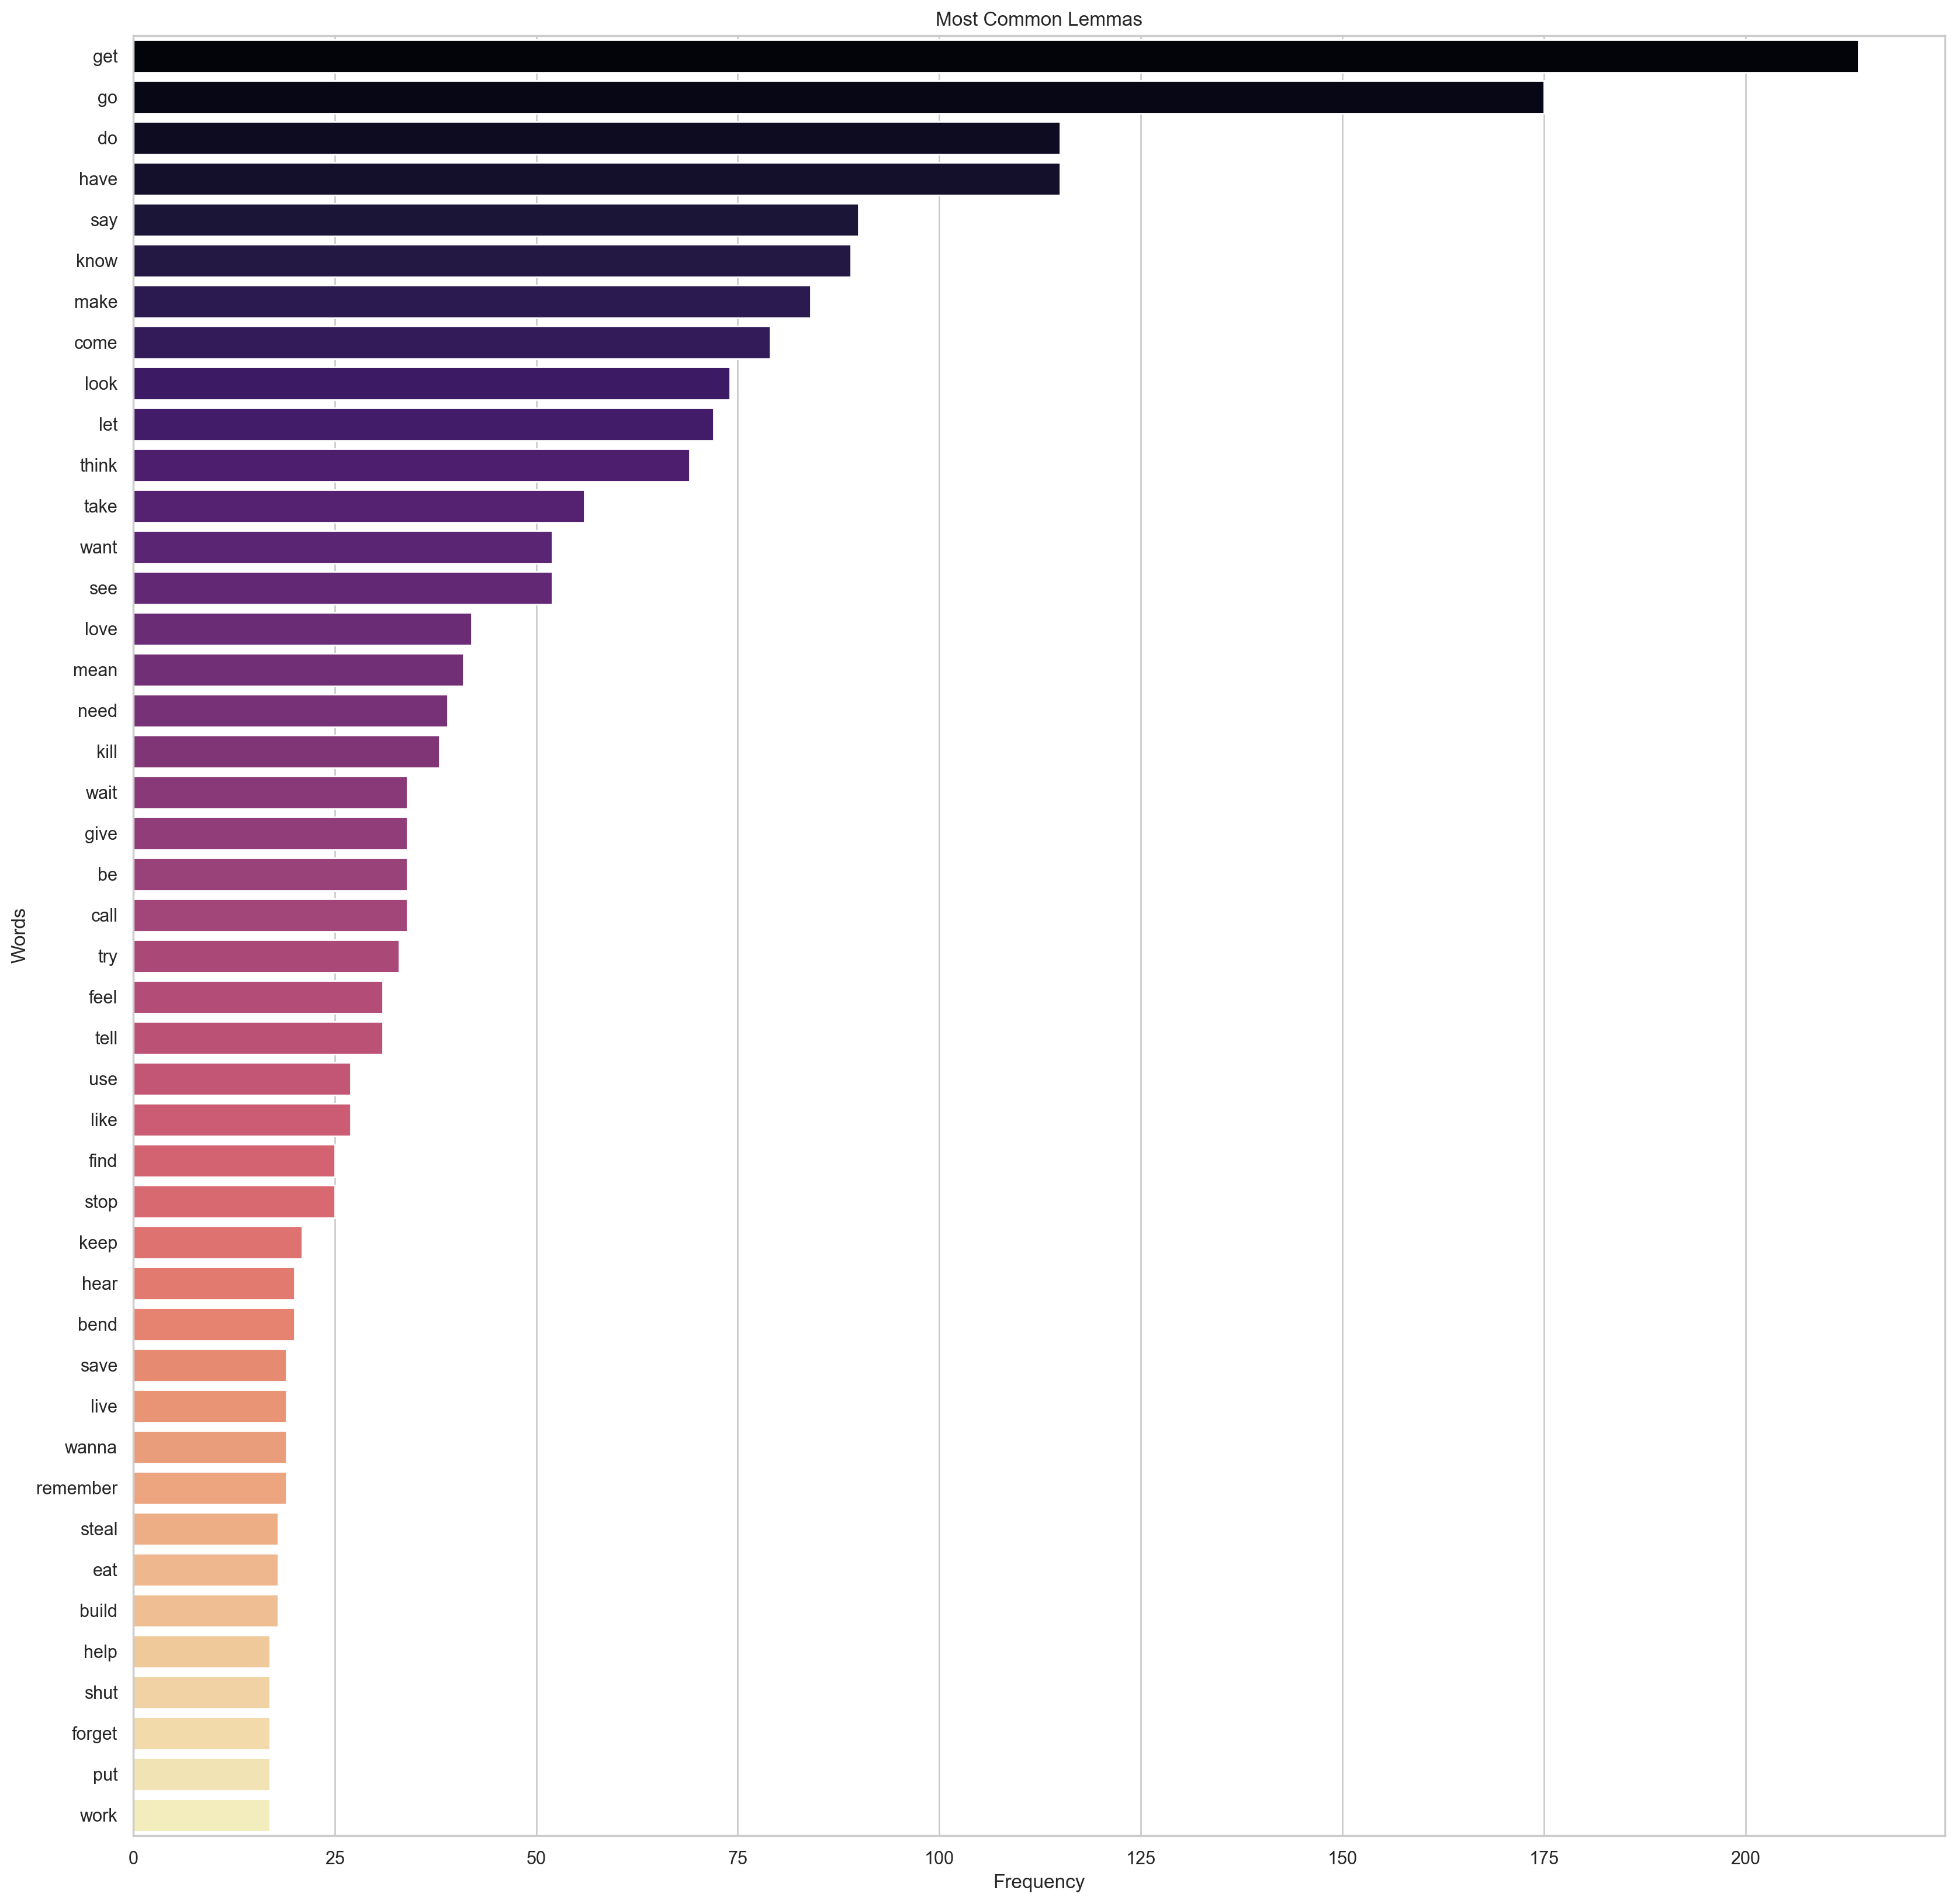

In [11]:
# We don't want to plot every last word here. But we have a lot of data, so we can experiment
# To access data in our Counter list and keep it organized from highest to lowest value, we use `most_common()`.
# Then we can slice it to store however many we want to plot. [:10] would plot the first 11 values since python starts counting from zero.

mostCommon = dict(lemmaFreq.most_common()[:44])
print(f"mostCommon Lemmas {mostCommon}")

# Turns out after some tinkering that the seaborn library wants to collect its x and y values from lists. 
# So I'm just unpacking the values and keys, and checking to make sure they remain in their dictionary order here. 
counts = list(mostCommon.values())
lems = list(mostCommon.keys())
print(counts)
print(lems)

# This is to help matplotlib to display plots inline in the Jupyter Notebook
%matplotlib inline
# Set figure size configuration
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(20,20))

# Create bar plot using seaborn
sns.set(style="whitegrid")
sns.barplot(x=counts, y=lems, palette="magma")

# Adding labels and title
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Most Common Lemmas')


# Show plot
plt.show()


# Check out the SVG :-)
The next cell is just here to show you what SVG code looks like "under the hood": SVG is a kind of XML, and we can output it programmatically to make shapes and lines and apply colors based on data. Click on the cell to see what the code looks like underneath: we'll be exploring this code in more detail soon! 

In [ ]:
%%writefile simple.svg
<svg xmlns="http://www.w3.org/2000/svg" width="100%" height="100%">
    <desc><!--You could write a description of this SVG here.--></desc>
    <g alignment-baseline="baseline" transform="translate (25, 100)">
        <!--The "g" element just lets us *group* stuff together. -->
        <circle cx="320" cy="80" r="50" stroke="red" fill="orange" stroke-width="4"/>  
     <circle cx="250" cy="150" r="100" stroke="red" fill="purple" stroke-width="4"/>  
        
       
        
        <!--<line x1="25" y1="-5" x2="500" y2="500" stroke="red" stroke-width="3"/>-->
        
        <line x1="25" y1="300" x2="700" y2="300" stroke="purple" stroke-width="20"/>
       <!--line above is the x axis of my graph -->
        
        <line x1="25" y1="300" x2="25" y2="0" stroke="green" stroke-width="10"/>
        
        <line x1="25" y1="250" x2="700" y2="250" stroke="purple" stroke-width="2"/>
        
        <text x="15" y="230" fill="purple" style="font-family:serif;font-size:15px; writing-mode: tb; glyph-orientation-vertical: 5">50</text>
        
        <line x1="25" y1="100" x2="700" y2="100" stroke="purple" stroke-width="2"/>
        <text x="15" y="90" fill="purple" style="font-family:sans-serif;font-size:15px; writing-mode: tb; glyph-orientation-horizontal: 5">75</text>
    </g>
</svg>

<img src="simple.svg" height="100%"/>